# Friction optimization

## Import

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

import gym_gyroscope_env
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import prbs
import torch

import matplotlib.pyplot as plt
%matplotlib inline

## Environment Class and Modules

In [2]:
# Initialization args
env_name = 'GyroscopeEnv-v1'
state = np.zeros([7])
simu_args = {
    'dt': 0.02,
    'ep_len': 100,
    'seed': 2
}
reward_func = 'Normalized'
reward_args = {
    'k': 0.05, 
    'qx2': 0.01, 
    'qx4': 0.01, 
    'pu1': 0.5, 
    'pu2': 0.5
}

# Create env
env = create_env(env_name,simu_args,reward_func,reward_args, state)

## Helpful functions

In [3]:
u = prbs(10,10)

In [4]:
def read_data(filepath):
    
    # count lines
    file = open(filepath, "r")
    count = len(file.readlines(  ))
    data = np.empty([count, 16])
    file.seek(0)
    
    # read each line as a numpy array
    row = 0
    for x in file:
        data[row] = np.array(x.split('\t')).astype(np.float)
        row += 1
    file.close()
    
    # change time from usec into sec and shift the beginning to 0
    data[:,11] = data[:,11] / 1e6
    data[:,11] -= data[0,11]
    
    return data

In [5]:
time = np.arange(0, 60, env.dt)
state_record = np.empty([len(time), 7])

data_red = read_data('data_red.txt')
data_red[:,2] = data_red[:,2]/180*np.pi # deg to rad
data_red[:,3] = data_red[:,3]*2*np.pi/60 # rpm to rad/s
data_red = data_red[:len(time)]

data_blue = read_data('data_blue.txt')
data_blue[:,4] = data_blue[:,4]/180*np.pi # deg to rad
data_blue[:,5] = data_blue[:,5]*2*np.pi/60 # rpm to rad/s
data_blue = data_blue[:len(time)]

In [6]:
def simulate(mode):
    
    x_0 = [0,0,0,0,0,0,0]
    observation = env.reset(x_0)

    for i in range(len(time)):
        if mode == 'red':
            action = [u[i],0] 
        else:
            action = [0,u[i]]
        observation, reward, done, info = env.step(action)
        state_record[i] = env.state
        
    return time, state_record

In [7]:
def loss(x, mode, fig=False):
    
    env.fvr = 0.002679
    env.fcr = 0
    env.fvb = 0.005308
    env.fcb = 0
    
    if mode == 'red':
        env.fvr = x[0]
        env.fcr = x[1]
        time, data_s = simulate(mode)
        l = np.square(data_red[:,2] - data_s[:,0]).mean() + 4*np.square(data_red[:,3] - data_s[:,1]).mean()
        
        if fig:
        
            f, axs = plt.subplots(2,1,figsize=(14,10))

            plt.subplot(2,1,1)
            plt.title('Red gimbal angle',fontsize=20)
            plt.xlabel('time [s]',fontsize=16)
            plt.ylabel(r'$\theta$ [rad]',fontsize=16)
            plt.grid()
            plt.plot(time,data_s[:,0])
            plt.plot(time,data_red[:,2])
            plt.xlim([0,60])
            plt.legend(['Virtual env', 'Real gyro'],fontsize=16)

            plt.subplot(2,1,2)
            plt.title('Red gimbal speed',fontsize=20)
            plt.xlabel('time (s)',fontsize=16)
            plt.ylabel(r'$\dot \theta$ [rad/s]',fontsize=16)
            plt.grid()
            plt.plot(time,data_s[:,1])
            plt.plot(time,data_red[:,3])
            plt.xlim([0,60])
            plt.legend(['Virtual env', 'Real gyro'],fontsize=16)

    else:
        env.fvb = x[0]
        env.fcb = x[1]
        time, data_s = simulate(mode)
        l = np.square(data_blue[:,4] - data_s[:,2]).mean() + 4*np.square(data_blue[:,5] - data_s[:,3]).mean()
        
        if fig:
        
            f, axs = plt.subplots(2,1,figsize=(14,10))

            plt.subplot(2,1,1)
            plt.title('Blue gimbal angle',fontsize=20)
            plt.xlabel('time [s]',fontsize=16)
            plt.ylabel(r'$\phi$ [rad]',fontsize=16)
            plt.grid()
            plt.plot(time,data_s[:,2])
            plt.plot(time,data_blue[:,4])
            plt.xlim([0,60])
            plt.legend(['Virtual env', 'Real gyro'],fontsize=16)

            plt.subplot(2,1,2)
            plt.title('Blue gimbal speed',fontsize=20)
            plt.xlabel('time (s)',fontsize=16)
            plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
            plt.grid()
            plt.plot(time,data_s[:,3])
            plt.plot(time,data_blue[:,5])
            plt.xlim([0,60])
            plt.legend(['Virtual env', 'Real gyro'],fontsize=16)

    return l

## Red gimbal optimization

9209.8868031186

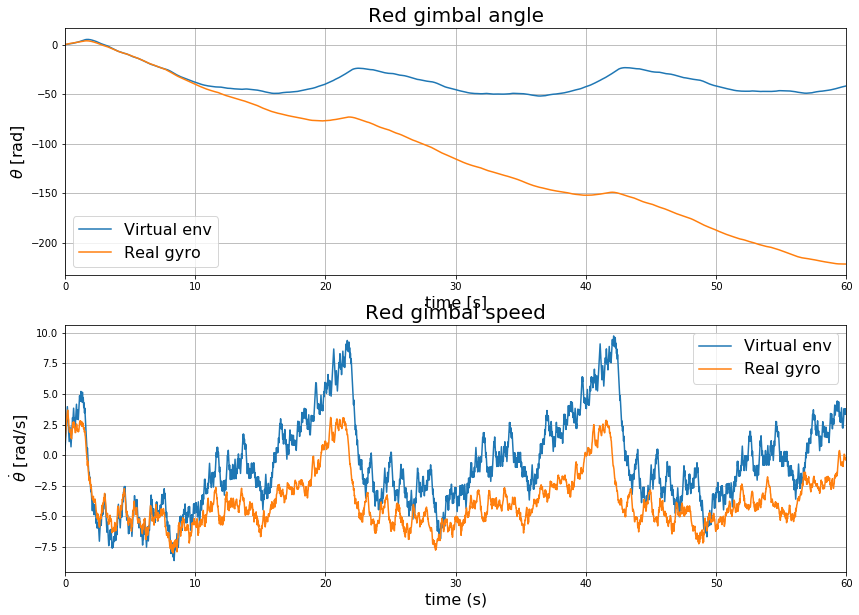

In [8]:
loss([0.002679, 0], 'red', True)

1909.6776411538763

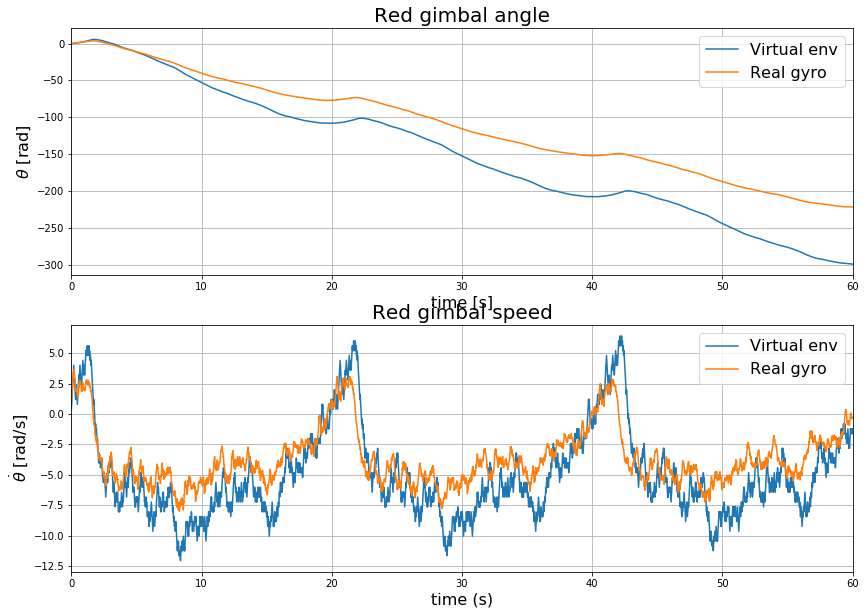

In [9]:
loss([0, 0], 'red', True)

In [10]:
bnds = ((0, None), (0, None))
res_red = minimize(loss, [0, 0], ('red'), bounds=bnds)

In [11]:
res_red

      fun: 153.9073320240398
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.08513756e-01, 1.68260344e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 12
     njev: 26
   status: 0
  success: True
        x: array([0.00029031, 0.        ])

153.9073320240398

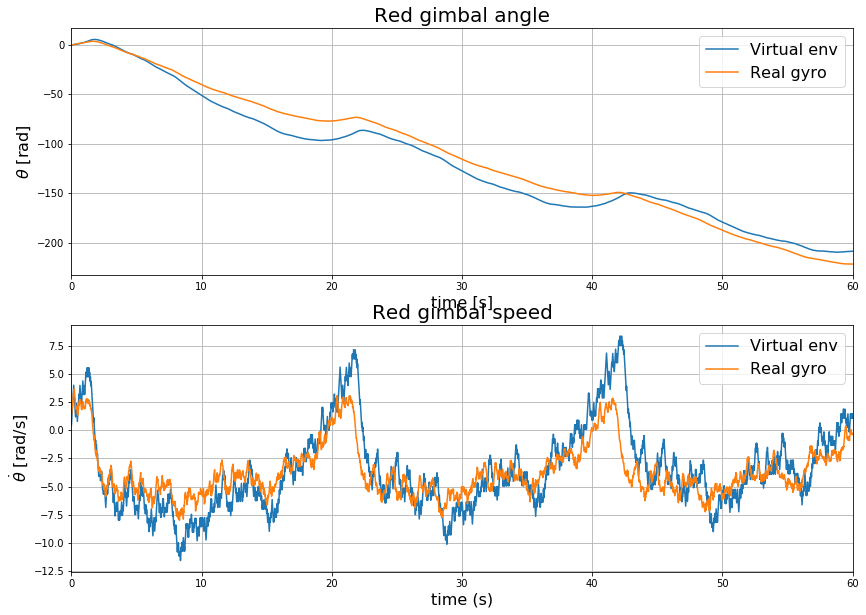

In [12]:
loss(res_red.x, 'red', True)

## Blue gimbal optimization

53709.34554460286

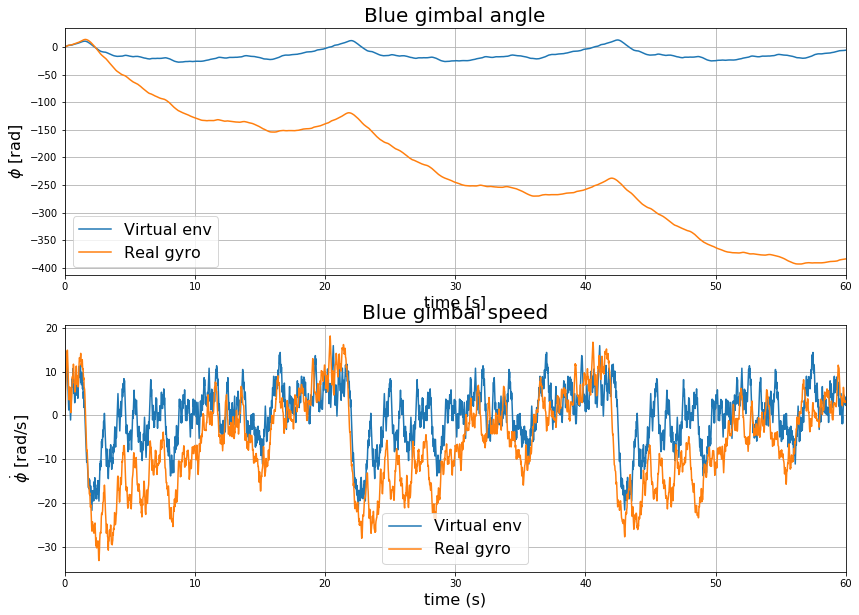

In [13]:
loss([0.005308, 0], 'blue', True)

234117.4914446342

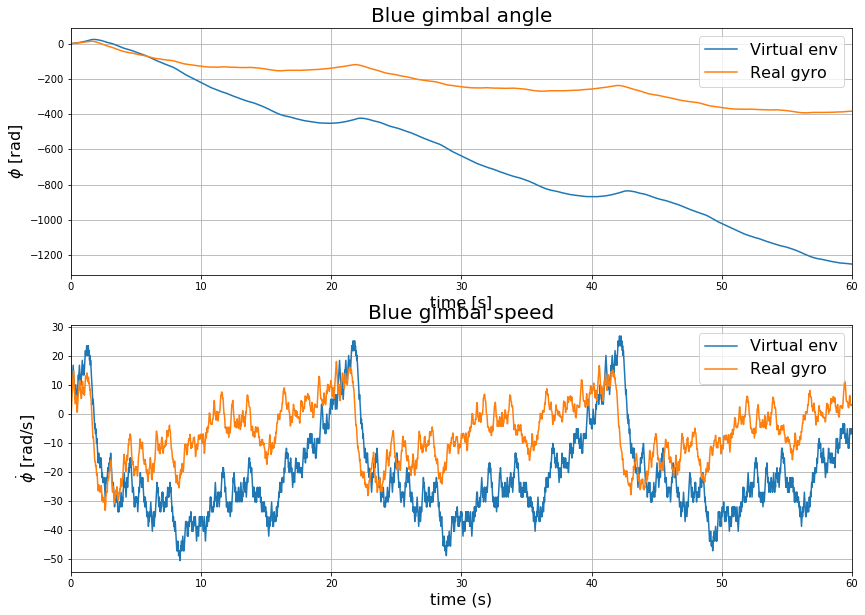

In [14]:
loss([0, 0], 'blue', True)

In [15]:
bnds = ((0, None), (0, None))
res_blue = minimize(loss, [0, 0], ('blue'), bounds=bnds)

In [16]:
res_blue

      fun: 7506.066232331162
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1578318.10320285, 1160305.06106433])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 330
      nit: 10
     njev: 110
   status: 2
  success: False
        x: array([7.09810586e-05, 3.21620766e-03])

7506.066261240575

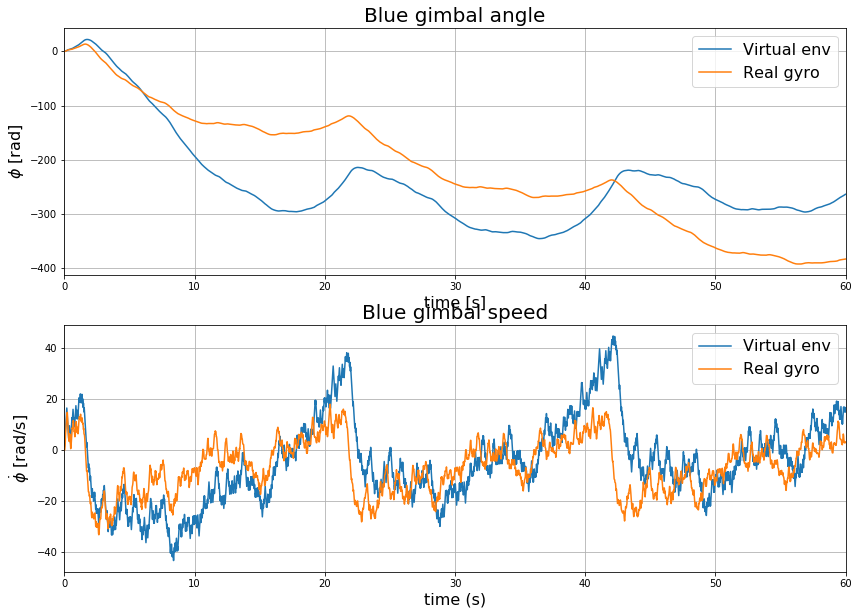

In [17]:
loss(res_blue.x, 'blue', True)